<a href="https://colab.research.google.com/github/NexusSin/Currency-Classification-Using-Convolutional-Neural-Network-CNN-/blob/main/Project_Deep_Learning_Fabio_Dollaku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project:** Currency Classification Using Convolutional Neural Network (CNN)

**Student:** Fabio Dollaku

**ID:** 0240655845

**Email:** fabio.dollaku.001@student.uni.lu

This project, "*Currency Classification Using Convolutional Neural Network (CNN)*," creates a deep learning model to identify different types of currencies, using a dataset similar to the MNIST handwritten digit collection. Built in Google Colab, the project processes images of currencies and trains a model to recognize and classify them accurately, without focusing on specific currency values.

The project is designed to be clear and presentable, with the code organized into steps that are easy to follow. It produces visual results, such as charts and heatmaps, to show how well the model performs and highlight which parts of the images it uses to make decisions. These visuals are saved for a compelling presentation to demonstrate the models ability to classify currencies effectively.

**Download the CSV file to the Dataset Directory**

In [1]:
!pip install -q gdown
!gdown 1vNa8-mw_KRsB-ais-9fXxurxbefDg-rG

import pandas as pd
df = pd.read_csv('datasets.csv')

!mkdir -p /content/Dataset/
!mv datasets.csv /content/Dataset/

Downloading...
From: https://drive.google.com/uc?id=1vNa8-mw_KRsB-ais-9fXxurxbefDg-rG
To: /content/datasets.csv
100% 94.0M/94.0M [00:00<00:00, 122MB/s]


**Import All Dependencies**

In [2]:
# Import all libraries and verify TensorFlow

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os

print(f"TensorFlow version: {tf.__version__}")
print("All dependencies imported successfully")
print("Environment setup complete. Run the next cell.")

TensorFlow version: 2.18.0
All dependencies imported successfully
Environment setup complete. Run the next cell.


**Preprocess Dataset**

In [3]:
# Normalize, reshape, and augment preloaded dataset

def load_and_preprocess_data(data_path, img_height=64, img_width=64, channels=1):
    df = pd.read_csv(data_path)

    print("Dataset Preview:")
    print(df.head())
    print("\nDataset Shape:", df.shape)
    print("Columns:", df.columns.tolist())

    if 'label' not in df.columns:
        raise ValueError("Dataset must contain a 'label' column.")

    unique_labels = sorted(df['label'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    print("Label Mapping:", label_to_idx)
    y = df['label'].map(label_to_idx).values

    X = df.drop('label', axis=1).values
    if X.max() == X.min():
        print("Warning: Uniform pixels detected. Applying contrast stretching.")
        X = (X - X.min()) / (X.max() - X.min() + 1e-8)
    else:
        X = X / 255.0

    expected_features = img_height * img_width * channels
    if X.shape[1] != expected_features:
        raise ValueError(f"Expected {expected_features} features, got {X.shape[1]}.")

    X = X.reshape(-1, img_height, img_width, channels)
    print("X Shape after reshape:", X.shape)

    X_aug = np.array([augment_image(image).numpy() for image in X])

    num_classes = len(unique_labels)
    y = pd.get_dummies(y).values
    class_names = [f'Currency_{label}' for label in unique_labels]

    return X_aug, y, class_names, num_classes

def augment_image(image):
    image = tf.reshape(image, [64, 64, 1])
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[64, 64, 1])
    return image

data_path = '/content/Dataset/datasets.csv'

IMG_HEIGHT, IMG_WIDTH, CHANNELS = 64, 64, 1
try:
    X_aug, y, class_names, NUM_CLASSES = load_and_preprocess_data(data_path, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
    print("Dataset loaded and preprocessed. Run the next cell.")
except Exception as e:
    print(f"Error: {e}")


Dataset Preview:
    label  pixel 1  pixel 2  pixel 3  pixel 4  pixel 5  pixel 6  pixel 7  \
0  dollar      155      155      155      155      155      155      155   
1  dollar      227      227      227      227      227      227      227   
2  dollar      166      166      166      166      166      166      166   
3  dollar      232      232      232      232      232      232      232   
4  dollar      152      152      152      152      152      152      152   

   pixel 8  pixel 9  ...  pixel 4087  pixel 4088  pixel 4089  pixel 4090  \
0      155      155  ...         155         155         155         155   
1      227      227  ...         227         227         227         227   
2      166      166  ...         166         166         166         166   
3      232      232  ...         232         232         232         232   
4      152      152  ...         152         152         152         152   

   pixel 4091  pixel 4092  pixel 4093  pixel 4094  pixel 4095  pixel 

**Split Dataset**

In [4]:
# Split data into train, validation, and test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_aug, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

train_classes = np.sum(y_train, axis=0)
val_classes = np.sum(y_val, axis=0)
test_classes = np.sum(y_test, axis=0)
print("\nClass distribution (counts):")
print("Training:", train_classes)
print("Validation:", val_classes)
print("Test:", test_classes)

print("Dataset split complete. Run the next cell.")

Training set shape: (4199, 64, 64, 1) (4199, 6)
Validation set shape: (901, 64, 64, 1) (901, 6)
Test set shape: (900, 64, 64, 1) (900, 6)

Class distribution (counts):
Training: [700 700 699 700 700 700]
Validation: [150 150 151 150 150 150]
Test: [150 150 150 150 150 150]
Dataset split complete. Run the next cell.


**Define CNN Model**

In [6]:
# Create a convolutional neural network

def create_model(img_height=64, img_width=64, channels=1, num_classes=NUM_CLASSES):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels), name='conv2d_1'),
        tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_1'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_2'),
        tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_2'),
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(num_classes, activation='softmax', name='dense_2')
    ])
    return model

model = create_model(IMG_HEIGHT, IMG_WIDTH, CHANNELS, NUM_CLASSES)
model.summary()
print("Model defined. Run the next cell.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,350 (6.20 MB)

 Trainable params: 1,625,350 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Model defined. Run the next cell.


**Train Model**

In [8]:
# Compile and train the CNN

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

print("Training complete. Run the next cell.")

Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 37s 258ms/step - accuracy: 0.9948 - loss: 0.0157 - val_accuracy: 0.9900 - val_loss: 0.0309
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.9933 - loss: 0.0241 - val_accuracy: 0.9867 - val_loss: 0.0289
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.9991 - loss: 0.0072 - val_accuracy: 0.9911 - val_loss: 0.0378
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9933 - val_loss: 0.0249
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 1.0000 - loss: 3.0349e-04 - val_accuracy: 0.9933 - val_loss: 0.0250
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 1.0000 - loss: 2.3221e-04 - val_accuracy: 0.9956 - val_loss: 0.0245
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 1.0000 - loss: 1.2598e-04 - val_accuracy: 0.9956 - val_loss: 0.0250
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 1.00

**Evaluate Model**

In [9]:
# Block 6: Evaluate Model
# Purpose: Evaluate model on test set

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Evaluation complete. Run the next cell.")

Test Loss: 0.0528
Test Accuracy: 0.9956
Evaluation complete. Run the next cell.


**Visualize Training History**

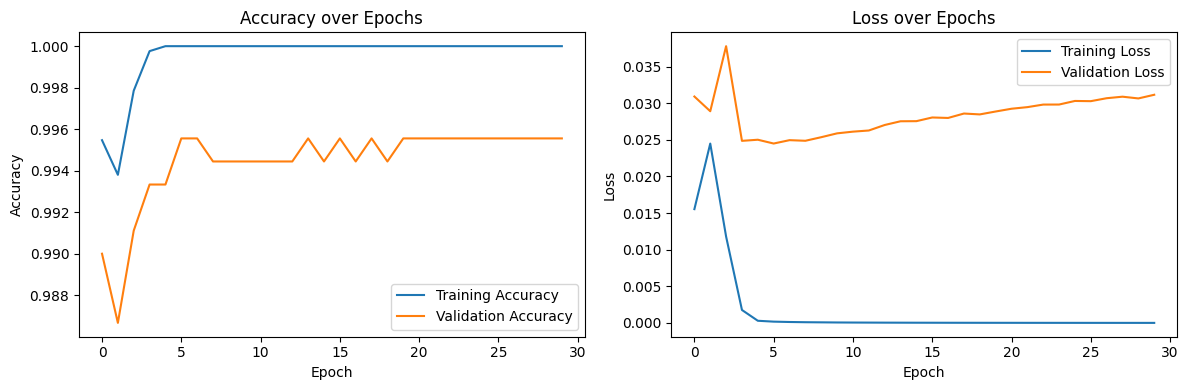

Visualization complete. Run the next cell.


In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print("Visualization complete. Run the next cell.")

**Make Predictions**

In [11]:
# Block 8: Make Predictions
# Purpose: Predict classes for test set

y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print("Predictions shape:", y_pred.shape)
print("Predictions complete. Run the next cell.")

Predictions shape: (900, 6)
Predictions complete. Run the next cell.


**Display Predictions**

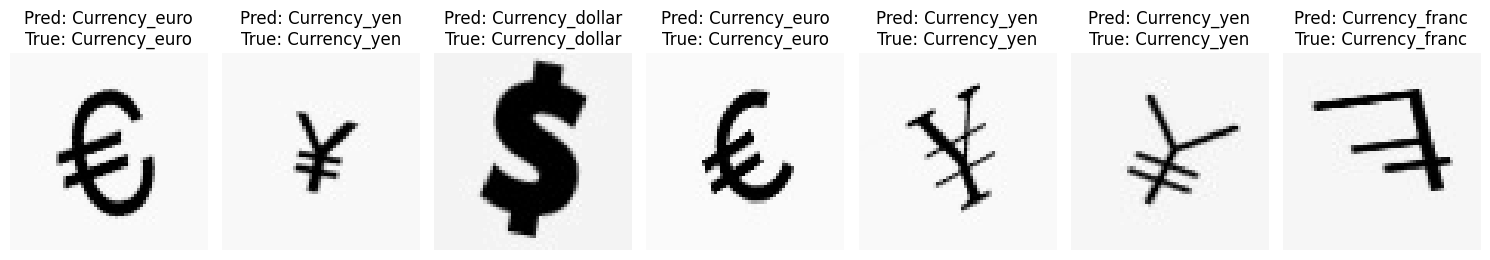

Sample predictions displayed. Run the next cell.


In [12]:
# Show sample test images with predictions

num_samples = 7
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
    plt.title(f"Pred: {class_names[y_pred_classes[i]]}\nTrue: {class_names[y_true_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
print("Sample predictions displayed. Run the next cell.")

**Implement Grad-CAM**

In [13]:
# Generate Grad-CAM heatmaps for visualizing model focus

# Ensure matplotlib inline
%matplotlib inline

def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    # Validate input shape
    if img_array.shape[1:] != (64, 64, 1):
        raise ValueError(f"Expected img_array shape (None, 64, 64, 1), got {img_array.shape}")

    # Verify layer exists
    try:
        last_conv_layer = model.get_layer(last_conv_layer_name)
    except ValueError:
        raise ValueError(f"Layer {last_conv_layer_name} not found. Available layers: {[layer.name for layer in model.layers]}")

    # Test model prediction
    sample_input = tf.zeros((1, 64, 64, 1))
    sample_output = model.predict(sample_input, verbose=0)
    print("Sample output shape:", sample_output.shape)

    # Check prediction for input image
    pred = model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    pred_conf = pred[0, pred_class]
    print(f"Image prediction: class {pred_class} ({class_names[pred_class]}), confidence {pred_conf:.4f}")

    # Check input image quality
    img_mean = np.mean(img_array[0])
    img_std = np.std(img_array[0])
    print(f"Input image stats: mean {img_mean:.4f}, std {img_std:.4f}")

    # Convert Sequential to Functional model
    inputs = tf.keras.Input(shape=(64, 64, 1))
    x = inputs
    current_shape = (None, 64, 64, 1)  # Initial input shape

    for layer in model.layers:
        layer_config = layer.get_config()
        layer_copy = type(layer).from_config(layer_config)
        try:
            layer_copy.build(current_shape)
        except Exception as e:
            raise ValueError(f"Failed to build layer {layer.name}: {str(e)}")
        layer_copy.set_weights(layer.get_weights())
        x = layer_copy(x)
        current_shape = layer_copy.compute_output_shape(current_shape)
        print(f"Layer {layer.name} output shape:", current_shape)

    functional_model = tf.keras.Model(inputs=inputs, outputs=x)

    # Create Grad-CAM model
    try:
        grad_model = tf.keras.Model(
            inputs=inputs,
            outputs=[functional_model.get_layer(last_conv_layer_name).output, functional_model.output]
        )
    except Exception as e:
        raise ValueError(f"Failed to create Grad-CAM model: {str(e)}")

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        print("Warning: Gradients are None")
        return np.zeros((29, 29))

    # Debug gradients
    grads_mean = tf.reduce_mean(tf.abs(grads))
    print(f"Gradients mean magnitude: {grads_mean:.6f}")

    # Normalize gradients to amplify weak values
    grads_max = tf.reduce_max(tf.abs(grads))
    if grads_max > 0:
        grads = grads / (grads_max + 1e-8)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap_max = tf.math.reduce_max(heatmap)
    if heatmap_max < 1e-7:
        print(f"Warning: Heatmap max value too low ({heatmap_max})")
        return np.zeros((29, 29))
    heatmap = heatmap / (heatmap_max + 1e-8)

    heatmap_np = heatmap.numpy()
    print(f"Heatmap shape: {heatmap_np.shape}, min: {heatmap_np.min()}, max: {heatmap_np.max()}")
    return heatmap_np

def superimpose_heatmap(heatmap, img, alpha=0.4):
    if not np.any(heatmap):
        print("Warning: Empty heatmap received")
        return np.uint8(255 * img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img = np.uint8(255 * img)
    if img.shape[-1] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    print(f"Superimposed image shape: {superimposed_img.shape}, min: {superimposed_img.min()}, max: {superimposed_img.max()}")
    return superimposed_img

last_conv_layer_name = 'conv2d_2'
print("Grad-CAM function defined. Run the next cell.")

Grad-CAM function defined. Run the next cell.


**Visualize Grad-CAM**

Sample output shape: (1, 6)
Image prediction: class 1 (Currency_euro), confidence 1.0000
Input image stats: mean 0.7694, std 0.3241
Layer conv2d_1 output shape: (None, 62, 62, 32)
Layer max_pooling2d_1 output shape: (None, 31, 31, 32)
Layer conv2d_2 output shape: (None, 29, 29, 64)
Layer max_pooling2d_2 output shape: (None, 14, 14, 64)
Layer flatten output shape: (None, 12544)
Layer dense_1 output shape: (None, 128)
Layer dense_2 output shape: (None, 6)
Gradients mean magnitude: 0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sample output shape: (1, 6)
Image prediction: class 5 (Currency_yen), confidence 1.0000
Input image stats: mean 0.8691, std 0.1345
Layer conv2d_1 output shape: (None, 62, 62, 32)
Layer max_pooling2d_1 output shape: (None, 31, 31, 32)
Layer conv2d_2 output shape: (None, 29, 29, 64)
Layer max_pooling2d_2 output shape: (None, 14, 14, 64)
Layer flatten output shape: (None, 12544)
Layer dense_1 output shape: (None, 128)
Layer dense_2 output shape: (None, 6)
Gradients me

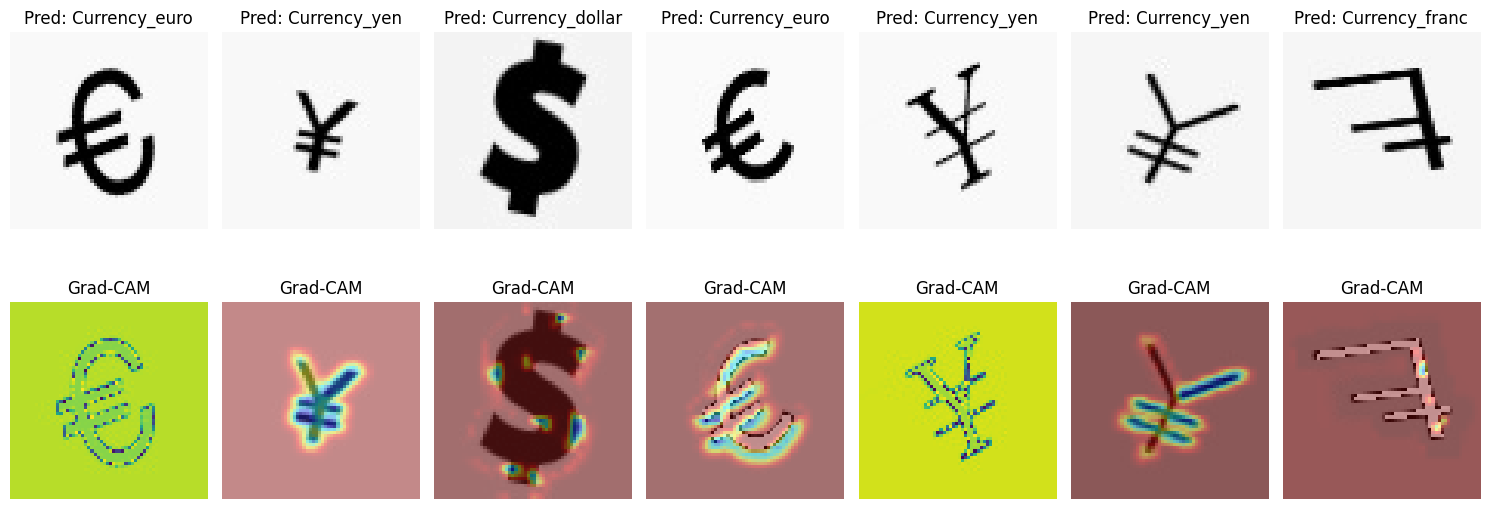

Grad-CAM visualization complete.


In [14]:
# Display test images with Grad-CAM heatmaps

num_samples = 7
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    img = X_test[i][np.newaxis, ...]
    heatmap = get_gradcam_heatmap(model, img, last_conv_layer_name)
    superimposed_img = superimpose_heatmap(heatmap, X_test[i])

    plt.subplot(2, num_samples, i+1)
    plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
    plt.title(f"Pred: {class_names[np.argmax(model.predict(img), axis=1)[0]]}")
    plt.axis('off')

    plt.subplot(2, num_samples, i+1+num_samples)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()
print("Grad-CAM visualization complete.")